# Poker AI Setup

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pokerenv.obs_indices as indices
from pokerenv.table import Table
from treys import Deck, Evaluator, Card
from pokerenv.common import GameState, PlayerState, PlayerAction, TablePosition, Action, action_list
from pokerenv.player import Player
from pokerenv.utils import pretty_print_hand, approx_gt, approx_lte
import types
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gym
import math
import time
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn.functional import huber_loss, cross_entropy


Python(74850) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


## Create enviorment

In [2]:
class ModifiedTable(Table):
    def __init__(self, n_players, player_names=None, track_single_player=False, stack_low=50, stack_high=200, hand_history_location='hands/', invalid_action_penalty=0):
        super().__init__(n_players, player_names, track_single_player, stack_low, stack_high, hand_history_location, invalid_action_penalty)
        
    def _int_to_str(card_int: int) -> str:
        rank_int = Card.get_rank_int(card_int)
        suit_int = Card.get_suit_int(card_int)
        return Card.STR_RANKS[rank_int] + Card.INT_SUIT_TO_CHAR_SUIT[suit_int]
    
    def _get_rank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 8) & 0xF
        else:
            return (card_int[0] >> 8) & 0xF
        
    def _get_suit_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 12) & 0xF
        else:
            return (card_int[0] >> 12) & 0xF
        
    def _get_bitrank_int(card_int: int) -> int:
        if card_int is int:
            return (card_int >> 16) & 0x1FFF
        else:
            return (card_int[0] >> 16) & 0x1FFF

    def _get_prime(card_int: int) -> int:
        if card_int is int:
            return card_int & 0x3F
        else:
            return card_int[0] & 0x3F

    def _street_transition(self, transition_to_end=False):
            transitioned = False
            if self.street == GameState.PREFLOP:
                self.cards = self.deck.draw(3)
                self._write_event("*** FLOP *** [%s %s %s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2])))
                self.street = GameState.FLOP
                transitioned = True
            if self.street == GameState.FLOP and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** TURN *** [%s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3])))
                self.street = GameState.TURN
                transitioned = True
            if self.street == GameState.TURN and (not transitioned or transition_to_end):
                new = self.deck.draw(1)[0]
                self.cards.append(new)
                self._write_event("*** RIVER *** [%s %s %s %s] [%s]" %
                                (Card.int_to_str(self.cards[0]), Card.int_to_str(self.cards[1]),
                                Card.int_to_str(self.cards[2]), Card.int_to_str(self.cards[3]),
                                Card.int_to_str(self.cards[4])))
                self.street = GameState.RIVER
                transitioned = True
            if self.street == GameState.RIVER and (not transitioned or transition_to_end):
                if not self.hand_is_over:
                    if self.hand_history_enabled:
                        self._write_show_down()
                self.hand_is_over = True
            self.street_finished = False
            self.last_bet_placed_by = None
            self.first_to_act = None
            self.bet_to_match = 0
            self.minimum_raise = 0
            for player in self.players:
                player.finish_street()

    def step(self, action: Action):
        BB = 5
        self.current_player_i = self.next_player_i
        player = self.players[self.current_player_i]
        self.current_turn += 1

        if (player.all_in or player.state is not PlayerState.ACTIVE) and not self.hand_is_over:
            raise Exception("A player who is inactive or all-in was allowed to act")
        if self.first_to_act is None:
            self.first_to_act = player

        # Apply the player action
        if not (self.hand_is_over or self.street_finished):
            valid_actions = self._get_valid_actions(player)
            if not self._is_action_valid(player, action, valid_actions):
                player.punish_invalid_action()
            elif action.action_type is PlayerAction.FOLD:
                player.fold()
                self.active_players -= 1
                self._write_event("%s: folds" % player.name)
            elif action.action_type is PlayerAction.CHECK:
                player.check()
                self._write_event("%s: checks" % player.name)
            elif action.action_type is PlayerAction.CALL:
                call_size = player.call(self.bet_to_match)
                self.pot += call_size
                if player.all_in:
                    self._write_event("%s: calls $%.2f and is all-in" % (player.name, call_size * BB))
                else:
                    self._write_event("%s: calls $%.2f" % (player.name, call_size * BB))
            elif action.action_type is PlayerAction.BET:
                previous_bet_this_street = player.bet_this_street
                actual_bet_size = player.bet(np.round(action.bet_amount, 2))
                self.pot += actual_bet_size
                if self.bet_to_match == 0:
                    if player.all_in:
                        self._write_event("%s: bets $%.2f and is all-in" % (player.name, actual_bet_size * BB))
                    else:
                        self._write_event("%s: bets $%.2f" % (player.name, actual_bet_size * BB))
                else:
                    if player.all_in:
                        self._write_event("%s: raises $%.2f to $%.2f and is all-in" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                    else:
                        self._write_event("%s: raises $%.2f to $%.2f" %
                                            (player.name,
                                            ((actual_bet_size + previous_bet_this_street) - self.bet_to_match) * BB,
                                            (actual_bet_size + previous_bet_this_street) * BB)
                                            )
                self._change_bet_to_match(actual_bet_size + previous_bet_this_street)
                self.last_bet_placed_by = player
            else:
                raise Exception("Error when parsing action, make sure player action_type is PlayerAction and not int")

            should_transition_to_end = False
            players_with_actions = [p for p in self.players if p.state is PlayerState.ACTIVE if not p.all_in]
            players_who_should_act = [p for p in players_with_actions if (not p.acted_this_street or p.bet_this_street != self.bet_to_match)]

            # If the game is over, or the betting street is finished, progress the game state
            if len(players_with_actions) < 2 and len(players_who_should_act) == 0:
                amount = 0
                # If all active players are all-in, transition to the end, allowing no actions in the remaining streets
                if self.active_players > 1:
                    biggest_bet_call = max(
                        [p.bet_this_street for p in self.players
                            if p.state is PlayerState.ACTIVE if p is not self.last_bet_placed_by]
                    )
                    last_bet_this_street = 0
                    if self.last_bet_placed_by is not None:
                        last_bet_this_street = self.last_bet_placed_by.bet_this_street
                    if biggest_bet_call < last_bet_this_street:
                        amount = last_bet_this_street - biggest_bet_call
                    should_transition_to_end = True
                # If everyone else has folded, end the hand
                else:
                    self.hand_is_over = True
                    amount = self.minimum_raise
                # If there are uncalled bets, return them to the player who placed them
                if amount > 0:
                    self.pot -= amount
                    self.last_bet_placed_by.stack += amount
                    self.last_bet_placed_by.money_in_pot -= amount
                    self.last_bet_placed_by.bet_this_street -= amount
                    self._write_event(
                        "Uncalled bet ($%.2f) returned to %s" % (amount * BB, self.last_bet_placed_by.name)
                    )
                if should_transition_to_end:
                    self._street_transition(transition_to_end=True)
            # If the betting street is still active, choose next player to act
            else:
                active_players_after = [i for i in range(self.n_players) if i > self.current_player_i if
                                        self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                active_players_before = [i for i in range(self.n_players) if i <= self.current_player_i if
                                            self.players[i].state is PlayerState.ACTIVE if not self.players[i].all_in]
                if len(active_players_after) > 0:
                    self.next_player_i = min(active_players_after)
                else:
                    self.next_player_i = min(active_players_before)
                next_player = self.players[self.next_player_i]
                if self.last_bet_placed_by is next_player or (self.first_to_act is next_player and self.last_bet_placed_by is None):
                    self.street_finished = True
                    if len(active_players_before) > 0:
                        self.next_player_i = min(active_players_before)

        if self.street_finished and not self.hand_is_over:
            self._street_transition()

        obs = np.zeros(self.observation_space.shape[0]) if self.hand_is_over else self._get_observation(self.players[self.next_player_i])
        rewards = np.asarray([player.get_reward() for player in sorted(self.players)])
        if self.hand_is_over:
            self._distribute_pot()
            self._finish_hand()
            
        return obs, rewards, self.hand_is_over, {}

In [3]:
# Create the enviorment:
def createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player=False):
    table = ModifiedTable(active_players, 
                player_names=player_names,
                track_single_player=track_single_player,
                stack_low=low_stack_bbs,
                stack_high=high_stack_bbs,
                hand_history_location=hand_history_location,
                invalid_action_penalty=invalid_action_penalty
    )
    table.seed(1)
    return table
            

## Env Modifications

## Learning Loop

In [4]:
def learningLoop(table, agents, active_players, n_iterations):
    iteration = 1
    playerWinnings = [[0 for player in table.players]]
    winners = []
    while True:
        if iteration % 50 == 0:
            table.hand_history_enabled = True
        table.n_players = active_players
        for agent in agents:
            if hasattr(agent, "update_policy"):
                agent.update_policy(winners)
            agent.reset()
        obs = table.reset()
        winners = []
        acting_player = int(obs[indices.ACTING_PLAYER])
        while True:
            action = agents[acting_player].get_action(obs)
            obs, reward, done, _ = table.step(action)
            if  done:
                # Distribute final rewards
                for i in range(active_players):
                    agents[i].rewards.append(reward[i])
                break
            else:
                # This step can be skipped unless invalid action penalty is enabled, 
                # since we only get a reward when the pot is distributed, and the done flag is set
                agents[acting_player].rewards.append(reward[acting_player])
                acting_player = int(obs[indices.ACTING_PLAYER])
        iteration += 1
        playerWinnings.append([player.winnings for player in table.players])
        
        for agent, player in zip(agents, table.players):
            if player.winnings > 0:
                winners.append((agent, player))
                
        table.hand_history_enabled = False
        if iteration % 250 == 0:
            print("Iteration: ", iteration)
        
        if iteration >= n_iterations:
            break
    
    return playerWinnings

# Agents

## Random Agent

In [5]:
# Agent that makes random actions
class RandomAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        chosen_action = PlayerAction(np.random.choice(valid_actions))
        bet_size = 0
        if chosen_action is PlayerAction.BET:
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Fold Agent

In [6]:
# Agent that always folds
class FoldAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Determined Agent

In [7]:
# Agent that never folds
class DeterminedAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.CALL
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, 0)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Aggressive agent

In [8]:
# Agent that always raises
class AggressiveAgent:
    def __init__(self):
        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        chosen_action = PlayerAction.BET
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        table_action = Action(chosen_action, valid_bet_high)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []
        
    

## Chance agent

In [9]:
# Agent that uses encoded hand values to make decisions
class ValueAgent:
    def __init__(self, value_model):
        self.actions = []
        self.observations = []
        self.rewards = []
        self.value_model = value_model

    def get_action(self, observation):
        self.observations.append(observation)
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_bet_low = observation[indices.VALID_BET_LOW]
        valid_bet_high = observation[indices.VALID_BET_HIGH]
        hand_value = observation[indices.ACTING_PLAYER_STACK_SIZE]
        pot_size = observation[indices.POT_SIZE]
        bet_value = self.value_model.predict(np.array([[hand_value, pot_size]]))[0][0]
        
        if bet_value > 0.5:
            chosen_action = PlayerAction.BET
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)
        elif valid_bet_high == 0.0:
            chosen_action = PlayerAction.CALL
        else:
            chosen_action = PlayerAction.FOLD
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        return table_action

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## Q-Learning Agent

In [10]:
class QLearningAgent:
    def __init__(self, eta=0.1, gamma=0.95, epsilon=0.1):
        self.q_table = {}  # Q-table to store state-action values
        self.eta = eta      # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate

        self.actions = []
        self.observations = []
        self.rewards = []

    def get_action(self, observation):
        # Convert observation into a hashable state
        state = tuple(observation)

        # Get valid actions dynamically
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()

        # Initialize Q-values for new states
        if state not in self.q_table:
            self.q_table[state] = {action: 0.0 for action in valid_actions}

        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            chosen_action = np.random.choice(valid_actions)
        else:
            # Choose action with the highest Q-value
            chosen_action = max(self.q_table[state], key=self.q_table[state].get)

        # Convert chosen action to PlayerAction enum
        chosen_action = PlayerAction(chosen_action)

        # Determine bet size if the action is BET
        bet_size = 0
        if chosen_action == PlayerAction.BET:
            valid_bet_low = observation[indices.VALID_BET_LOW]
            valid_bet_high = observation[indices.VALID_BET_HIGH]
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)

        # Create the action object
        table_action = Action(chosen_action, bet_size)
        self.actions.append(table_action)
        self.observations.append(observation)
        return table_action

    def _get_reward(self, observation, winners):
        winning_agents = [agent for agent, player in winners]
        winning_players = [player for agent, player in winners]
        pot = observation[indices.POT_SIZE]
        
        if self in winning_agents:
            winning_idx = winning_agents.index(self)
            player = winning_players[winning_idx]
            stack = player.stack
            return 
        else:
            return 0
    
    def update_policy(self, winners):
        # Update Q-values using the Q-learning update rule
        for i in range(len(self.observations)):
            state = tuple(self.observations[i])
            action = self.actions[i]
            reward = self._get_reward(self.observations[i], winners)
            next_state = tuple(self.observations[i + 1]) if i + 1 < len(self.observations) else None

            if next_state is not None:
                next_max = max(self.q_table[next_state].values())
            else:
                next_max = 0

            self.q_table[state][action.action_type.value] += self.eta * (
                reward + self.gamma * next_max - self.q_table[state][action.action_type.value]
            )

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []

## REgression to RElative REward Based RL Agent

In [11]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [12]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_actions):
        super(PolicyNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:

class ReBeLAgent:
    def __init__(self, model_params):
        """
        Initialize the ReBeL agent.
        :param model_params: Dictionary with network dimensions and hyperparameters.
        """
        self.num_actions = model_params['num_actions']
        self.value_network = self._build_value_network(model_params)
        self.policy_network = self._build_policy_network(model_params)
        self.regret = {}
        self.strategy = {}

    def _build_value_network(self, params):
        """
        Build the value network for PBS value approximation.
        :param params: Dictionary with input_size, hidden_size, output_size.
        """
        input_size = params['input_size']
        hidden_size = params['hidden_size']
        output_size = params['output_size']
        return nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def _build_policy_network(self, params):
        """
        Build the policy network for action probability prediction.
        :param params: Dictionary with input_size, hidden_size, num_actions.
        """
        input_size = params['input_size']
        hidden_size = params['hidden_size']
        num_actions = params['num_actions']
        return nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_actions),
            nn.Softmax(dim=-1)
        )

    def compute_strategy(self, pbs):
        """
        Compute the strategy for the given PBS using CFR.
        :param pbs: Public Belief State representation (hashable).
        """
        if pbs not in self.regret:
            self.regret[pbs] = np.zeros(self.num_actions)
        regrets = self.regret[pbs]
        positive_regrets = np.maximum(regrets, 0)
        strategy = positive_regrets / positive_regrets.sum() if positive_regrets.sum() > 0 else np.ones(self.num_actions) / self.num_actions
        self.strategy[pbs] = strategy
        return strategy

    def update_networks(self, training_data):
        """
        Update the value and policy networks using training data.
        :param training_data: List of tuples (state, value, policy).
        """
        value_optimizer = Adam(self.value_network.parameters(), lr=0.001)
        policy_optimizer = Adam(self.policy_network.parameters(), lr=0.001)

        for state, target_value, target_policy in training_data:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            value_target_tensor = torch.tensor(target_value, dtype=torch.float32)
            policy_target_tensor = torch.tensor(target_policy, dtype=torch.float32)

            # Update value network
            value_optimizer.zero_grad()
            value_prediction = self.value_network(state_tensor)
            value_loss = huber_loss(value_prediction, value_target_tensor, delta=1.0)
            value_loss.backward()
            value_optimizer.step()

            # Update policy network
            policy_optimizer.zero_grad()
            policy_prediction = self.policy_network(state_tensor)
            policy_loss = cross_entropy(policy_prediction, policy_target_tensor)
            policy_loss.backward()
            policy_optimizer.step()

    def play(self, pbs):
        """
        Select an action using the trained policy network.
        :param pbs: Current Public Belief State (environment state encoding).
        """
        pbs_tensor = torch.tensor(pbs, dtype=torch.float32)
        action_probabilities = self.policy_network(pbs_tensor).detach().numpy()
        return np.random.choice(self.num_actions, p=action_probabilities)
    
    def get_action(self, observation):
        pbs = make_pbs(observation)
        action = self.play(pbs)
        table_action = make_table_action(action)
        return table_action
    
    def make_pbs(observation):
        return 


In [14]:
class REBELAgent:
    def __init__(self, eta=0.1):
        self.actions = []
        self.observations = []
        self.rewards = []
        self.scaler = StandardScaler()
        self.regressor = SGDRegressor()  # Regression model for action-value scores
        self.eta = eta  # Learning rate for policy updates

        # Initialize regressor with dummy data
        dummy_X = np.zeros((1, 63))  # Replace 63 with the correct feature size
        dummy_y = [0]
        self.regressor.partial_fit(dummy_X, dummy_y)

    def get_action(self, observation):
        self.observations.append(observation)

        # Get valid actions
        valid_actions = np.argwhere(observation[indices.VALID_ACTIONS] == 1).flatten()
        valid_action_types = [action_list[i] for i in valid_actions]  # Map to PlayerAction

        # Compute scores for each valid action
        action_scores = []
        for action_type in valid_action_types:
            encoded_action = self._encode_action(observation, Action(action_type, 0))
            action_scores.append(self.regressor.predict([encoded_action])[0])

        # Apply softmax to compute probabilities
        action_probs = self._softmax(action_scores)

        # Sample an action based on probabilities
        chosen_action_idx = np.random.choice(len(valid_action_types), p=action_probs)
        chosen_action = valid_action_types[chosen_action_idx]  # Use PlayerAction enum

        # Determine bet size if the chosen action is a bet
        bet_size = 0
        if chosen_action == PlayerAction.BET:
            valid_bet_low = observation[indices.VALID_BET_LOW]
            valid_bet_high = observation[indices.VALID_BET_HIGH]
            bet_size = np.random.uniform(valid_bet_low, valid_bet_high)

        table_action = Action(chosen_action, bet_size)  # Use PlayerAction
        self.actions.append(table_action)
        return table_action

    def _softmax(self, scores):
        exp_scores = np.exp(scores - np.max(scores))  # Subtract max for numerical stability
        return exp_scores / np.sum(exp_scores)

    def update_policy(self, winners):
        X = []
        y = []

        for obs, action in zip(self.observations, self.actions):
            action_features = self._encode_action(obs, action)
            reward = self._get_reward(obs, winners)
            X.append(action_features)
            y.append(reward)

        # Convert X to a numpy array and ensure it's 2D
        X = np.array(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)  # Reshape to 2D if necessary

        # Handle case where X or y is empty
        if len(X) == 0 or len(y) == 0:
            return
        
        X = self.scaler.fit_transform(X)
        self.regressor.partial_fit(X, y)

    def _encode_action(self, observation, action):
        action_vector = np.zeros(len(action_list))
        action_vector[action.action_type.value] = 1  # Use the value of PlayerAction
        bet_feature = np.array([action.bet_amount])
        return np.concatenate([observation, action_vector, bet_feature])

    def _get_reward(self, observation, winners):
        if self in winners:
            return 1
        else:
            return 0

    def reset(self):
        self.actions = []
        self.observations = []
        self.rewards = []


# Run Throughs

## Rebel vs ineffective agents

In [15]:
active_players = 6
agents = [REBELAgent(), RandomAgent(), FoldAgent(), DeterminedAgent(), AggressiveAgent(), RandomAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(2)


In [16]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration:  250
Iteration:  500
Iteration:  750
Iteration:  1000
Iteration:  1250
Iteration:  1500
Iteration:  1750
Iteration:  2000
Iteration:  2250
Iteration:  2500
Iteration:  2750
Iteration:  3000
Iteration:  3250
Iteration:  3500
Iteration:  3750
Iteration:  4000
Iteration:  4250
Iteration:  4500
Iteration:  4750
Iteration:  5000
Iteration:  5250
Iteration:  5500
Iteration:  5750
Iteration:  6000
Iteration:  6250
Iteration:  6500
Iteration:  6750
Iteration:  7000
Iteration:  7250
Iteration:  7500
Iteration:  7750
Iteration:  8000
Iteration:  8250
Iteration:  8500
Iteration:  8750
Iteration:  9000
Iteration:  9250
Iteration:  9500
Iteration:  9750
Iteration:  10000


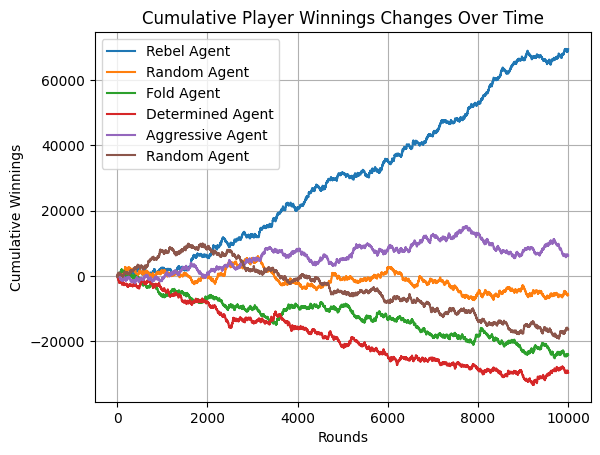

In [17]:
players = ["Rebel Agent", "Random Agent", "Fold Agent", "Determined Agent", "Aggressive Agent", "Random Agent"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 3 Rebels vs 3 Random

In [18]:
active_players = 6
agents = [REBELAgent(), REBELAgent(), RandomAgent(), RandomAgent(), REBELAgent(), RandomAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(2)


In [19]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration:  250
Iteration:  500
Iteration:  750
Iteration:  1000
Iteration:  1250
Iteration:  1500
Iteration:  1750
Iteration:  2000
Iteration:  2250
Iteration:  2500
Iteration:  2750
Iteration:  3000
Iteration:  3250
Iteration:  3500
Iteration:  3750
Iteration:  4000
Iteration:  4250
Iteration:  4500


KeyboardInterrupt: 

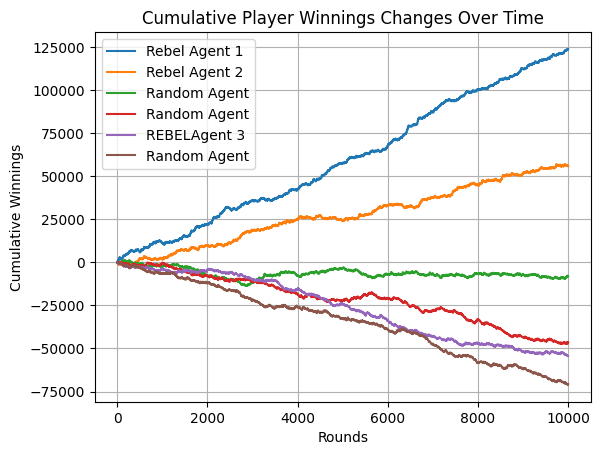

In [ ]:
players = ["Rebel Agent 1", "Rebel Agent 2", "Random Agent", "Random Agent", "REBELAgent 3", "Random Agent"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 1 Rebel 3 Q-Learning 2 Random

In [ ]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(), RandomAgent(), QLearningAgent(), RandomAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(3)

In [ ]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

[<__main__.RandomAgent object at 0x13e4367b0>, <__main__.QLearningAgent object at 0x13e437ce0>]
[<__main__.QLearningAgent object at 0x13e605df0>, <__main__.RandomAgent object at 0x11585a4b0>]
[<__main__.RandomAgent object at 0x11585a4b0>, <__main__.RandomAgent object at 0x13e4367b0>]
Iteration:  250
[<__main__.REBELAgent object at 0x13e435580>, <__main__.RandomAgent object at 0x11585a4b0>]
Iteration:  500
[<__main__.QLearningAgent object at 0x111061be0>, <__main__.RandomAgent object at 0x13e4367b0>]
[<__main__.QLearningAgent object at 0x13e605df0>, <__main__.QLearningAgent object at 0x111061be0>]
[<__main__.RandomAgent object at 0x13e4367b0>, <__main__.QLearningAgent object at 0x13e437ce0>]
Iteration:  750
Iteration:  1000
[<__main__.RandomAgent object at 0x11585a4b0>, <__main__.QLearningAgent object at 0x111061be0>]
[<__main__.REBELAgent object at 0x13e435580>, <__main__.RandomAgent object at 0x13e4367b0>]
[<__main__.REBELAgent object at 0x13e435580>, <__main__.RandomAgent object at 0

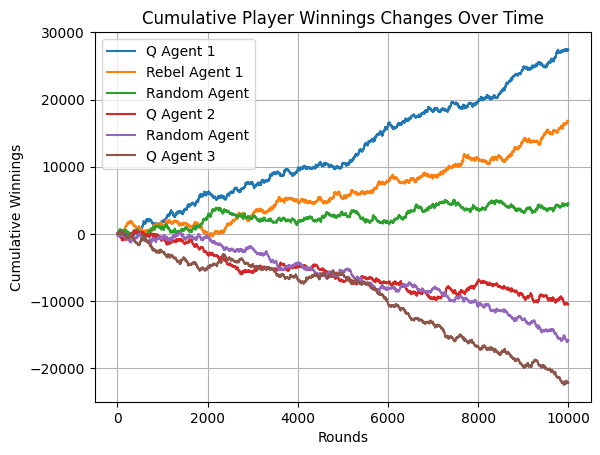

In [ ]:
players = ["Q Agent 1", "Rebel Agent 1", "Random Agent", "Q Agent 2", "Random Agent", "Q Agent 3"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 3 Rebel vs 3 Q-Learning

In [ ]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(), REBELAgent(), QLearningAgent(), REBELAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(3)

In [ ]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration:  250
[<__main__.REBELAgent object at 0x13e656ae0>, <__main__.QLearningAgent object at 0x13db77f20>]
Iteration:  500
Iteration:  750
[<__main__.QLearningAgent object at 0x13e65a360>, <__main__.QLearningAgent object at 0x13e6057c0>]
[<__main__.REBELAgent object at 0x13e656ae0>, <__main__.REBELAgent object at 0x13d186f60>]
Iteration:  1000
[<__main__.REBELAgent object at 0x13d5b6870>, <__main__.QLearningAgent object at 0x13e6057c0>]
[<__main__.REBELAgent object at 0x13d5b6870>, <__main__.REBELAgent object at 0x13d186f60>]
[<__main__.QLearningAgent object at 0x13e65a360>, <__main__.QLearningAgent object at 0x13e6057c0>]
[<__main__.REBELAgent object at 0x13e656ae0>, <__main__.REBELAgent object at 0x13d186f60>]
Iteration:  1250
[<__main__.REBELAgent object at 0x13e656ae0>, <__main__.REBELAgent object at 0x13d5b6870>]
[<__main__.REBELAgent object at 0x13e656ae0>, <__main__.QLearningAgent object at 0x13db77f20>]
[<__main__.QLearningAgent object at 0x13e65a360>, <__main__.QLearningAg

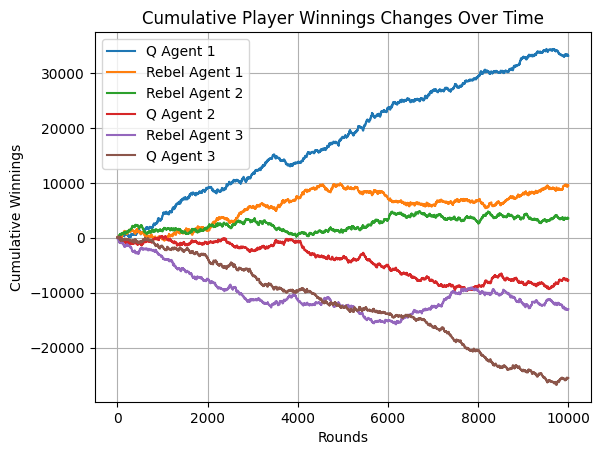

In [ ]:
players = ["Q Agent 1", "Rebel Agent 1", "Rebel Agent 2", "Q Agent 2", "Rebel Agent 3", "Q Agent 3"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## 1 Rebel vs 5 Q-Learning

In [ ]:
active_players = 6
agents = [QLearningAgent(), REBELAgent(), QLearningAgent(), QLearningAgent(), QLearningAgent(), QLearningAgent()]
player_names = {0: 'TrackedAgent1', 1: 'Agent2'} # Rest are defaulted to player3, player4...
# Should we only log the 0th players (here TrackedAgent1) private cards to hand history files
track_single_player = False
# Bounds for randomizing player stack sizes in reset()
low_stack_bbs = 99
high_stack_bbs = 100
hand_history_location = 'Hands/'
invalid_action_penalty = 10

table = createEnviorment(active_players, agents, player_names, low_stack_bbs, high_stack_bbs, hand_history_location, invalid_action_penalty, track_single_player)
table.seed(3)

In [ ]:
n_iterations = 10000
player_winnings = learningLoop(table, agents, active_players, n_iterations)

Iteration:  250
Iteration:  500
[<__main__.REBELAgent object at 0x13e5c4140>, <__main__.QLearningAgent object at 0x13e5c65d0>]
[<__main__.REBELAgent object at 0x13e5c4140>, <__main__.QLearningAgent object at 0x1158ae2d0>]
Iteration:  750
Iteration:  1000
Iteration:  1250
Iteration:  1500
Iteration:  1750
Iteration:  2000
Iteration:  2250
[<__main__.REBELAgent object at 0x13e5c4140>, <__main__.QLearningAgent object at 0x1158ae2d0>]
Iteration:  2500
[<__main__.REBELAgent object at 0x13e5c4140>, <__main__.QLearningAgent object at 0x13e5c65d0>]
Iteration:  2750
Iteration:  3000
[<__main__.REBELAgent object at 0x13e5c4140>, <__main__.QLearningAgent object at 0x13e656ab0>]
[<__main__.REBELAgent object at 0x13e5c4140>, <__main__.QLearningAgent object at 0x13e5c65d0>]
Iteration:  3250
[<__main__.QLearningAgent object at 0x13e654d70>, <__main__.QLearningAgent object at 0x13e656ab0>]
[<__main__.REBELAgent object at 0x13e5c4140>, <__main__.QLearningAgent object at 0x11553a540>]
Iteration:  3500
I

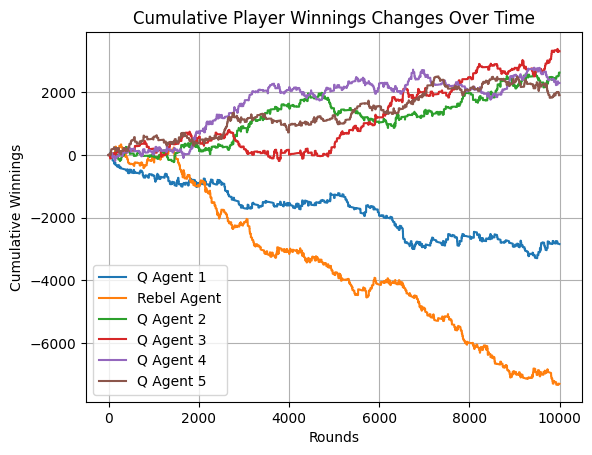

In [ ]:
players = ["Q Agent 1", "Rebel Agent", "Q Agent 2", "Q Agent 3", "Q Agent 4", "Q Agent 5"]

# Compute the running cumulative sum for each player
cumulative_player_stacks = np.cumsum(player_winnings, axis=0)

# Transpose to get stacks per player
cumulative_player_stacks_transposed = cumulative_player_stacks.T

# Plot cumulative stacks for each player
for i, cumulative_stack in enumerate(cumulative_player_stacks_transposed, start=1):
    plt.plot(cumulative_stack, label=f'{players[i-1]}')

# Add labels and legend
plt.xlabel('Rounds')
plt.ylabel('Cumulative Winnings')
plt.title('Cumulative Player Winnings Changes Over Time')
plt.legend()
plt.grid(True)
plt.show()